# Bert Training with Early Stopping

## 0. Setup

### 0.1 Install libraries

In [83]:
! pip install -r requirements.txt

# If you work with GPU-support:
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [84]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3070


## 1 Configuration

In [85]:
# Data variables
data_path = "../../data/training_data/labeled/labeled_data.xlsx" # path to the Excel file with the labeled data
validation_path = "../../data/validation_data/validation_data.csv" # path to where the validation set should be stored
results_path = "../../data/model_performance" # path to where the results should be stored
text_column_name = "expanded" # name of the column containing the text to classify
label_column_name = "label_strict" # name of the column containing the labels (0 = correct or 1 = incorrect)
num_labels = 2 # binary classification (see above)

# Model configuration
model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2 # ratio of the dataset to be used for testing
max_length = 512 # maximum length of the input sequences for BERT
num_epochs = 10 # number of epochs for training
batch_size = 8 # batch size for training and evaluation
learning_rate = 2e-5 # learning rate for the optimizer
weight_decay = 0.01 # weight decay for the optimizer
early_stopping_patience = 2 # number of epochs with no improvement after which training will be stopped

# Seed for reproducibility
import random
import numpy as np
from transformers import set_seed
import os

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Should 20% of the data be used for validation?
do_validation = True

## 2 Read and prepare dataset

In [86]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA
df = df[df['label'].notna()]

if do_validation == True:
    # Put 20 % of the data (with labels 0, 1, or -99) into a validation set
    df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['label'],
        random_state=seed
    )

    # Save validation set as 'validation_data.csv' at 'validation_path'
    val_df.to_csv(validation_path, index=False)

# Remove rows where 'label' is -99
df = df[df['label'] != -99]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance labels via undersampling (generalized)
label_counts = df['label'].value_counts()  # Get counts of each label
minority_label = label_counts.idxmin() # Get the minority label
majority_label = label_counts.idxmax() # Get the majority label

df_minority = df[df['label'] == minority_label]
df_majority = df[df['label'] == majority_label]

df_majority_downsampled = resample( # Downsample majority label
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=seed).reset_index(drop=True)

# Show head
df.head()

,text,label
0,"Following up, we found that sounds had no sign...",0
1,"However, pupil dilation was not significantly ...",0
2,See Tables S4 and S8 the outcomes and also did...,0
3,Post hoc analyses on self-related evaluations ...,0
4,"Further, there was no interaction of reference...",1


### 2.1 Create Train/Test set

In [87]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['label'])

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

Header of the Training set:

In [88]:
df_train.head()

,text,label
116,"Per Q&A interaction, men (M = 66.87 s, SD = 44...",1
439,"On the contrary, for negative affect, we found...",0
219,There was no association between reality monit...,1
562,Although the means of the two liking ratings d...,0
552,There was no difference between the self-and a...,1


In [89]:
# Check label balance in training set
print("Training label distribution:")
print(df_train['label'].value_counts())

Training label distribution:
label
1    227
0    227
Name: count, dtype: int64


Header of the Test set:

In [90]:
df_test.head()

,text,label
129,A 2 (condition: adversarial vs. benevolent) Ã—...,0
111,"As we expected, the effect of information seek...",0
212,"For relative changes in pupil size, we obtaine...",1
515,"First, the main effect of boosting consensus r...",0
173,"However, and in contrast to these findings, wh...",0


In [91]:
# Check label balance in test set
print("Test label distribution:")
print(df_test['label'].value_counts())

Test label distribution:
label
0    57
1    57
Name: count, dtype: int64


### 2.2 Tokenize 'text'

In [92]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_for_bert(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=max_length)

tokenized_train = train_dataset.map(tokenize_for_bert, batched=True)

tokenized_test = test_dataset.map(tokenize_for_bert, batched=True)

Map: 100%|██████████| 114/114 [00:00<00:00, 7204.54 examples/s]


## 3 Train BERT

### 3.1 Initializing model

In [93]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [94]:
# Standard Setup for training a model with Huggingface Transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=learning_rate, # Specify learning rate for BERT
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    seed=seed
)

# Model specific setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]  # Stop training if no improvement after 2 epochs
)

C:\Users\raphi\AppData\Local\Temp\ipykernel_7392\923563418.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [95]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693000,0.657961,0.675439,0.954545,0.368421,0.531646
2,0.471800,0.456220,0.798246,0.774194,0.842105,0.806723
3,0.179800,0.325214,0.903509,0.942308,0.859649,0.899083
4,0.046300,0.418572,0.912281,0.912281,0.912281,0.912281
5,0.019000,0.455622,0.903509,0.925926,0.877193,0.900901


TrainOutput(global_step=285, training_loss=0.28197239951083536, metrics={'train_runtime': 122.8346, 'train_samples_per_second': 36.96, 'train_steps_per_second': 4.64, 'total_flos': 418783383485400.0, 'train_loss': 0.28197239951083536, 'epoch': 5.0})

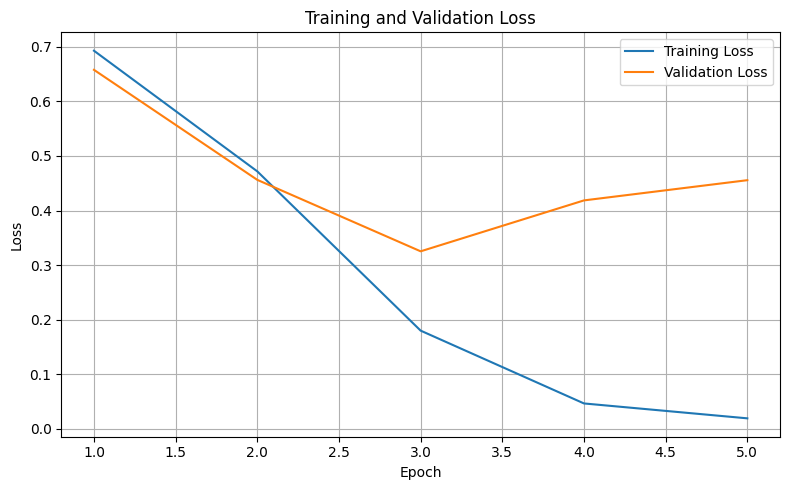

In [96]:
# Visualize loss curves
import matplotlib.pyplot as plt

# Extract training log history
logs = pd.DataFrame(trainer.state.log_history)

# Filter for loss values
loss_logs = logs[logs["loss"].notnull()][["epoch", "loss"]]
eval_logs = logs[logs["eval_loss"].notnull()][["epoch", "eval_loss"]]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(loss_logs["epoch"], loss_logs["loss"], label="Training Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3.2.1 Save last model

In [97]:
# Save the best model and tokenizer
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [98]:
from sklearn.metrics import classification_report

train_preds = trainer.predict(tokenized_train)
train_preds = np.argmax(train_preds.predictions, axis=1)
GT_train = df_train['label'].tolist()
print("Training Classification Report:")
print(classification_report(GT_train, train_preds))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       227
           1       1.00      0.97      0.99       227

    accuracy                           0.99       454
   macro avg       0.99      0.99      0.99       454
weighted avg       0.99      0.99      0.99       454



#### 3.3.2 Predict test data

In [99]:
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds.predictions, axis=1)
GT_test = df_test['label'].tolist()
print("Test Classification Report:")
print(classification_report(GT_test, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        57
           1       0.94      0.86      0.90        57

    accuracy                           0.90       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.90      0.90       114



In [100]:
# Save test results in 'classification_report.csv'

# Get classification report as a dict
report_dict = classification_report(GT_test, test_preds, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optionally reset index for nicer format
report_df = report_df.reset_index().rename(columns={"index": "class"})

# Save to CSV if you want
from pathlib import Path
report_df.to_csv(Path(results_path) / "classification_report.csv", index=False)

#### 3.3.3 4.3.3 Confusion-Matrix for test data

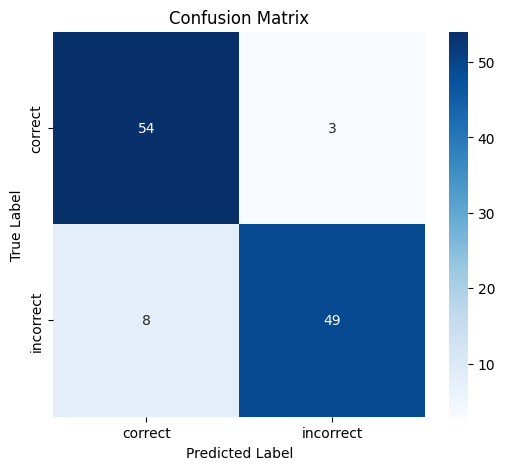

In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT_test, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["correct", "incorrect"],
            yticklabels=["correct", "incorrect"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the figure (before or after plt.show())
plt.savefig(Path(results_path) / "confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()

In [102]:
# F1 score printout
from sklearn.metrics import f1_score
print(f"Test F1 score: {f1_score(GT_test, test_preds):.3f}")

Test F1 score: 0.899


#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [103]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = test_preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [104]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 49)


,text
0,A negative binomial regression showed no diffe...
1,The magnitude of this effect was equivalent to...
2,Follow-up analyses indicated that these effect...
3,"Neither distance, Ï‡ 2 (1, N = 20) = 0.04, p =..."
4,"These analyses revealed that, compared with tr..."
5,"As expected, there was no difference between p..."
6,Results showed that for high-probability trial...
7,"In contrast, atomoxetine did not increase risk..."
8,The analyses revealed that infants' age in day...
9,"For the end-scale questions, there was no diff..."


In [105]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 54)


,text
0,A 2 (condition: adversarial vs. benevolent) Ã—...
1,"As we expected, the effect of information seek..."
2,"First, the main effect of boosting consensus r..."
3,"However, and in contrast to these findings, wh..."
4,Post hoc t tests revealed a sharp increase in ...
5,"The dyslexia (M = .87, SD = .05) and control (..."
6,"As in the previous studies, we examined the re..."
7,Results revealed no significant relationship b...
8,"Finally, we added relative height as a fixed f..."
9,There was not a significant main effect of rat...


In [106]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 3)


,text
0,"For low-probability trials, we also found no d..."
1,"In Experiment 2 (but not Experiment 1), there ..."
2,2 Adults demonstrated a significant familiarit...


In [107]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 8)


,text
0,"For relative changes in pupil size, we obtaine..."
1,These effects cannot be explained by the helme...
2,Further control analyses suggested that the mu...
3,"Again, we found no evidence that polarization ..."
4,Participants showed significantly greater vica...
5,Probability Ã— Time Constraint interaction on ...
6,Post hoc analysis indicated that the Component...
7,"However, the absence of a postresponse effect ..."


## 4 Storing results

### 4.1 Performance over the epochs

In [108]:
# Save log history
log_history = trainer.state.log_history

# Convert to DataFrame
log_df = pd.DataFrame(log_history)

# Save to CSV in 'results_path' folder
log_df.to_csv(Path(results_path) / "model_training_history.csv", index=False)

# Display the first few rows
print(log_df.head())

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6930   6.337064       0.000018    1.0    57        NaN            NaN   
1     NaN        NaN            NaN    1.0    57   0.657961       0.675439   
2  0.4718   9.081438       0.000016    2.0   114        NaN            NaN   
3     NaN        NaN            NaN    2.0   114   0.456220       0.798246   
4  0.1798   1.626608       0.000014    3.0   171        NaN            NaN   

   eval_precision  eval_recall   eval_f1  eval_runtime  \
0             NaN          NaN       NaN           NaN   
1        0.954545     0.368421  0.531646        0.5010   
2             NaN          NaN       NaN           NaN   
3        0.774194     0.842105  0.806723        0.4568   
4             NaN          NaN       NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                  227.530                 29.

### 4.2 Final performance on test set

In [109]:
# Save human and BERT labels on test set
predictions_df = pd.DataFrame({
    "human_label": GT_test,
    "BERT_label": test_preds
})
predictions_df.to_csv(Path(results_path) / "test_predictions.csv", index=False)

In [28]:
# The end...